# 

# Closed-Loop Simulation of the Pazy wing with SHARPy as a hardware-in-the-loop system

This tutorial exemplifies the application of an external controller on a nonlinear aeroelastic system using SHARPy as a hardware-in-the-loop system. The controller receives sensor measurements from SHARPy using an interface based on the User Datagram Protocol (UDP). After generating the control input, the control interface feeds this input back to the actuators incorporated in SHARPy again through the UDP interface.  


The notebook includes examples of the main methods in SHARPy for controller design, including both the generation of a linearized reduced-order model (ROM) of the nonlinear aeroelastic model (around a nonlinear equilibium point) for control design and, finally, how to apply their controller on a nonlinear aeroelastic simulation. The test case is the Pazy wing as modelled by Goizueta et al (JAircraft, 2022).

Reading material recommended are:

[1] Artola, M., Goizueta, N., Wynn, A., and Palacios, R., “Proof of Concept for a Hardware-in-the-Loop Nonlinear ControlFramework for Very Flexible Aircraft,”AIAA Scitech 2021 Forum, 2021. https://doi.org/10.2514/6.2021-1392.

[2] Stefanie Duessler, Thulasi Mylvaganam and Rafael Palacios. "LQG-based Gust Load Alleviation Systems for Very Flexible Aircraft," AIAA 2023-2571. AIAA SCITECH 2023 Forum. January 2023. https://doi.org/10.2514/6.2023-2571.

And other useful references for the Pazy model and Krylov-based model order reduction scheme are:

[3] Norberto Goizueta, Andrew Wynn, Rafael Palacios, Ariel Drachinsky, and Daniella E. Raveh, "Flutter Predictions for Very Flexible Wing Wind Tunnel Test",
Journal of Aircraft 2022 59:4, 1082-1097. https://doi.org/10.2514/1.C036710.

[4] Norberto Goizueta, Andrew Wynn, and Rafael Palacios, "Adaptive Sampling for Interpolation of Reduced-Order Aeroelastic Systems", AIAA Journal 2022 60:11, 6183-6202 https://doi.org/10.2514/1.J062050.

The notebook is structured such that first, we design the model and its operational point. Second, the model is linearized and reduced. The resulting reduced-order model (ROM) is then used for control design using Matlab. Third, we apply via a UDP Interface the designed controller on a nonlinear aeroelastic simulation performed with SHARPy.

Please note that this notebook requires 12 hours to be completed on a standard desktop computer. The longest simulation is the open-loop nonlinear gust response simulation taking around 8 hours, while the closed-loop nonlinear gust response simulation only takes 4 hours. 

## Requirements

This notebook needs to be run within the sharpy environment. Please check if you have installed SHARPy correctly. Matlab with a version of 2022 or newer is required for the preliminary control design (the matlab engine is also available in older versions of Matlab butno through pip install).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sharpy.cases.templates.flying_wings as wings
import sharpy.sharpy_main
import json

! pip install matlabengine
import matlab.engine

## Demonstrator Model 

The very-flexible Pazy wing serves as a demonstrator model and an aileron located near the wingtip as an actuator. The control objective in this example is to alleviate the wingtip displacement due to gust-induced wing loads. As an example, we use a P-controller implemented in a Python interface with the objective to reduce the wingtip displacement induced by a gust encounter. However, the reader can test any controller run on any platform as long as a working UDP connection to SHARPy is established. 

### Wind tunnel conditions

In [2]:
u_inf = 40 # m/s
alpha_deg = 1
rho = 1.225

### Wing and Wake Lattice Discretisation

Note that for convergence, we need a finer lattice grid. However, this would unnecessarily increase this notebook's duration which is already high enough with these coarse settings.

In [3]:
number_chordwise_panels = 4
number_spanwise_nodes = 16
wake_length_factor = 10

num_control_surfaces = 2

### General Simulation Settings

In [4]:
num_cores = 4
simulation_time =1.0

In [5]:
cases_folder = './cases/' # folder to store input files 
output_folder = './output' # folder to save results
route_notebook_dir =  os.path.abspath('')

## Open-Loop Gust Response
After, defining the general model settings, we now simulate the open-loop response of the Pazy wing to a gust. For this, we first have to generate input files for the Pazy model aerodynamic and structural properties, giving the above-defined flight conditions, discretisation, and simulation settings.

In [6]:
case_name = 'pazy_open_loop_gust_response'
pazy_model_open_loop = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,)

In [7]:
def generate_aero_and_fem_input_files(model):
    model.clean_test_files()
    model.update_derived_params()
    model.generate_aero_file()
    model.generate_fem_file()
    
generate_aero_and_fem_input_files(pazy_model_open_loop)

Next, we define the gust shape used, i.e. a 1-cosine gust with a gust length of 10 m and intensity of 2 %.

In [8]:
gust = True
gust_settings  ={'gust_shape': '1-cos',
                'gust_length': 10.,
                'gust_intensity': 0.02,
                'gust_offset': 0.}  

and create the final settings for the open-loop gust response simulation. Most importantly here, is the `flow` list which defines which solver will be run in which order. For more information about each solver, we kindly ask you to check our documentation (https://ic-sharpy.readthedocs.io/en/latest/content/solvers.html).

We are using the `get_setttings_udp` function to create our final settings. Basic settings can be adjusted by using different inputs. Please check the function code to be aware of the parameters used here.

In [9]:
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'AerogridPlot',
        'BeamPlot',
        'DynamicCoupled',
        ]
from get_settings_udp import get_settings_udp

pazy_model_open_loop.set_default_config_dict()
pazy_model_open_loop.config = get_settings_udp(pazy_model_open_loop,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings)
pazy_model_open_loop.config.write()

### Run SHARPy Simulation (open-loop test)
Having all input files ready, let us start the simulation. Note that this simulation takes up to eight hours. 


In [10]:
sharpy.sharpy_main.main(['', pazy_model_open_loop.route + pazy_model_open_loop.case_name + '.sharpy'])

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/rpalacio/sharpy/docs/source/content/example_notebooks/UDP_control
SHARPy being run is in /home/rpalacio/anaconda3/envs/sharpy/lib/python3.10/site-packages
SHARP

fatal: not a git repository (or any of the parent directories): .git


|  0  |  0  |  0.00000   | -0.0277  |  0.0000  |  1.9185  |  0.0000  |  0.0387  | -0.0000  |
|  1  |  0  |  -6.69935  | -0.0290  |  0.0000  |  1.9636  |  0.0000  |  0.0396  | -0.0000  |
|  0  |  1  |  0.00000   | -0.0566  |  0.0000  |  3.9396  | -0.0000  |  0.0794  | -0.0000  |
|  1  |  1  |  -6.06871  | -0.0592  |  0.0000  |  4.0325  | -0.0000  |  0.0812  | -0.0000  |
|  0  |  2  |  0.00000   | -0.0866  |  0.0000  |  6.0718  | -0.0000  |  0.1222  | -0.0000  |
|  1  |  2  |  -5.68671  | -0.0906  |  0.0000  |  6.2157  | -0.0000  |  0.1250  | -0.0000  |
|  0  |  3  |  0.00000   | -0.1177  |  0.0000  |  8.3244  | -0.0000  |  0.1673  | -0.0000  |
|  1  |  3  |  -5.40580  | -0.1233  |  0.0000  |  8.5230  | -0.0000  |  0.1712  | -0.0000  |
|  0  |  4  |  0.00000   | -0.1501  |  0.0000  | 10.7075  | -0.0000  |  0.2149  | -0.0000  |
|  1  |  4  |  -5.17976  | -0.1572  |  0.0000  | 10.9648  | -0.0000  |  0.2200  | -0.0000  |
Generating an instance of AerogridPlot
Variable include_forward_motion

#### Plot wing tip deflection in gust response

To get a feeling of the gust-induced deformation at the wingtip, we now display the vertical tip deflection.

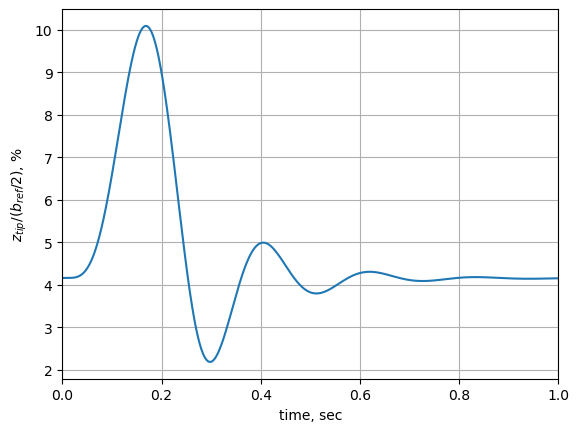

In [15]:
def get_resulting_vertical_tip_displacement(output_folder, model):    
    file_results = os.path.join(output_folder, 
                                 model.case_name, 
                                 'WriteVariablesTime',
                                 'struct_pos_node{}.dat'.format(model.num_node_surf))
    vertical_tip_displacement = np.loadtxt(file_results)[:,-1]
    
                                             
    return vertical_tip_displacement


tip_displacement_open_loop = get_resulting_vertical_tip_displacement(output_folder, 
                                                                     pazy_model_open_loop)


time_array = np.arange(0, len(tip_displacement_open_loop) * pazy_model_open_loop.dt, pazy_model_open_loop.dt)
normalised_tip_displacement = tip_displacement_open_loop/ (0.5*pazy_model_open_loop.b_ref) #normalise by half wing span
normalised_tip_displacement *=100# cconvert to percentnvert to percent
plt.plot(time_array, normalised_tip_displacement)
plt.xlabel('time, sec')
plt.ylabel('$z_{tip}/(b_{ref}/2)$, %')
plt.xlim([0., simulation_time])
plt.grid()
plt.show()

## Generate linear ROM

We continue with the linearization of the nonlinear aeroelastic model of the Pazy wing at the previously defined operational point and a subsequent reduction of the resulting linear state-space system. The structural and aerodynamic models are linearized and reduced separately and finally couple both resulting linear systems. Please see [2] for more details. 

The generation of the linear model for the coarse discretisation used, just takes a few seconds, as well as the execution of the linear response computation using Matlab. No need to skip anything here to save time. 

### Define Simulation Settings
We can re-use the simulation settings from the open-loop case with a few exceptions. Besides the name, of course, we need to extend the simulation `flow` list by the solvers needed for the linearization and export of the resulting linear state-space system. Further, we need to change the simulation time as we need to run only on the simulation timestep of the `DynamicCoupled` solver before the linearization. Also, no gust encounter is needed as we linearise the model around its equilibrium during steady-flight conditions.

In [16]:
case_name = 'pazy_ROM'

flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        'Modal',
        'LinearAssembler',
        'SaveData',
        ]

simulation_time_ROM = pazy_model_open_loop.dt # only one timestep has to be performed
gust = False

We further need to define the method used to reduce the linearized aerodynamic model. Here, we are going to apply a Krylov-based model order reduction scheme for the aerodynamic system, see [4] for more information. Please note that this is only one of the reduction methods implemented in SHARPy. We also offer various reduction schemes based on balancing methods.

In [17]:
use_rom = True
rom_settings = {
    'use': use_rom,
    'rom_method': 'Krylov',
    'rom_method_settings': {'Krylov': {
                                        'algorithm': 'mimo_rational_arnoldi',
                                        'r': 4, 
                                        'frequency': np.array([0]),
                                        'single_side': 'observability',
                                        },
                           }
                }

The linearised structural model is reduced by using modal projection and truncating non-dominant modes. Here, we keep the first 20 modes.

In [18]:
num_modes = 20


Further, we have deactivated the unsteady force contribution before generating the linear model and indicate that for the resulting linear system, we would like to retain the gust input for our preliminary control design study.

In [19]:
unsteady_force_contribution = False
remove_gust_input_in_statespace = False

### Generate Input Files
As before, we generate all necessary input files for the simulation.

In [20]:
pazy_model_ROM = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time_ROM,)

generate_aero_and_fem_input_files(pazy_model_ROM)


In [21]:
pazy_model_ROM.set_default_config_dict()
pazy_model_ROM.config = get_settings_udp(pazy_model_ROM,
                            flow,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings,
                            num_modes = num_modes,
                            rom_settings = rom_settings,
                            remove_gust_input_in_statespace=remove_gust_input_in_statespace,
                            unsteady_force_distribution=unsteady_force_contribution)
pazy_model_ROM.config.write()

### Run SHARPy Simulation
Before running SHARPy, we remove the old linear system generated if existing. It would cause an error that still needs to be fixed (your first contribution?).

In [22]:
if os.path.isfile(os.path.join(output_folder, pazy_model_ROM.case_name, 'savedata', pazy_model_ROM.case_name + '.linss.h5')):
    os.remove(os.path.join(output_folder, pazy_model_ROM.case_name, 'savedata', pazy_model_ROM.case_name + '.linss.h5'))

In [ ]:
sharpy.sharpy_main.main(['', pazy_model_ROM.route + pazy_model_ROM.case_name + '.sharpy'])

### Prepare Linear System for specific Controller
An overview of the generated linear ROM can be found near the end of the log file, including the number of states, inputs, and outputs as well as the indices mapped to each parameter. The saved linear ROM contains several unused input and output variables. The final simulation is expected to take 8 hours. Again, the results are uploaded *here* and it is still recommended to check if everything is running properly instead of skipping the entire simulation.

We start with reading the matrices from the h5 file and get rid of all unused input and output variables that are not needed for the control design. More precisely, we keep the gust and control surface inputs as well as the vertical tip displacements as an output. 

The system input includes the control surface deflection and its rate but does not know that they are related. For small timesteps, as for this case, we can assume a linear relationship through numerical gradients $\dot{\delta} = \frac{\delta - \delta^-}{dt}$ with *-* indicating the previous timestep.

Subsequently, we simulate the open-loop and closed-loop responses for different proportional gains of the P-controller.

But first, we save some parameters needed for this to a json file which is later loaded in the control script to avoid making changes in different files. 

In [25]:
folder_linear_results =os.path.join(output_folder, pazy_model_ROM.case_name,'linear_results')
if not os.path.exists(folder_linear_results):
    os.makedirs(folder_linear_results)
    
import scipy.io

parameter_matlab = {'num_aero_states': 80, # see log file
                    'num_modes': 20,  # see log file
                     'u_inf': float(pazy_model_ROM.u_inf),
                    'simulation_time': simulation_time,
                    'gust_length': float(gust_settings['gust_length']),
                    'gust_intensity': float(gust_settings['gust_intensity']),
                    'num_control_surfaces': num_control_surfaces,
                    'n_nodes': number_spanwise_nodes,
                    'control_input_start': 193 + 1, # see log file and + 1 for matlab indices
                    'gust_input_start': 192 + 1 , # see log file and + 1 for matlab indices
                   }

scipy.io.savemat(os.path.join(folder_linear_results, 'simulation_parameters.mat'), parameter_matlab)

Next, the matlab script *control_design_script.m* has to be executed which runs the linear open-loop gust response of this problem as well as two linear closed-loop gust responses using a P-controller with two different gain values. This P-controller is using the deviation of the vertical tip displacement to its reference condition as an error function. Finally, the script is saving the results as txt files in your output folder. 

Here, we use the MATLAB Engine API for Python to run the script:

In [26]:
eng = matlab.engine.start_matlab()
eng.control_design_script(route_notebook_dir)

In [ ]:
# Clean Up Simulink Files
import shutil
folder_path = os.path.join(route_notebook_dir, 'slprj')
if os.path.exists(folder_path):
    shutil.rmtree(folder_path)

file_path = os.path.join(route_notebook_dir,  'PID_linear_model.slxc')
if os.path.exists(file_path):
    os.remove(file_path)


### Postprocessing
Now, let us have a look at the linear results generated:

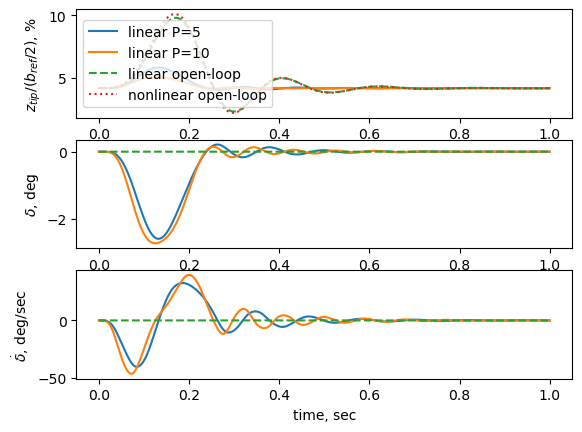

In [27]:
# Load linear results
tip_deflection_linear = np.loadtxt(folder_linear_results + '/tip_deflection.txt', delimiter = ',')
time_array_linear = np.loadtxt(folder_linear_results + '/time_array_linear.txt', delimiter = ',')
normalised_tip_deflection_linear = tip_deflection_linear / (0.5 *pazy_model_ROM.b_ref) * 100
control_surface_deflection_deg = np.loadtxt(folder_linear_results + '/deflection.txt', delimiter = ',')
control_surface_deflection_rate_deg = np.loadtxt(folder_linear_results + '/deflection_rate.txt', delimiter = ',')

# Plot Data
fig, axs = plt.subplots(3, 1)
list_linestyles = ['-', '-', '--', ':']
list_labels = ['linear P=5', 'linear P=10', 'linear open-loop', 'nonlinear open-loop']
for i in range(3):
    axs[0].plot(time_array_linear, normalised_tip_deflection_linear[:,i], list_linestyles[i], label=list_labels[i])

axs[0].plot(time_array, normalised_tip_displacement, list_linestyles[-1], label=list_labels[-1])
axs[0].legend()
axs[0].set(ylabel='$z_{tip}/(b_{ref}/2)$, %')

for i in range(3):
    axs[1].plot(time_array_linear, control_surface_deflection_deg[:,i], list_linestyles[i])
    
axs[1].set(ylabel='$\delta$, deg')
for i in range(3):
    axs[2].plot(time_array_linear, control_surface_deflection_rate_deg[:,i], list_linestyles[i])
    
axs[2].set(ylabel='$\dot{\delta}$, deg/sec')
for ax in axs.flat:
    ax.set(xlabel='time, sec')


We can see here the slightly higher peak tip deflection in the nonlinear response. Further, we see a significant reduction in tip deflection by the P-controller. Since we only have slightly higher aileron deflection and rates for the higher gain of P=10, we chose this gain value for the final control design applied to the nonlinear aeroelastic gust response simulation.

## Closed-Loop Nonlinear Gust Response
Now, we need a similar simulation setup as the open-loop nonlinear response and activate the gust again.

In [28]:
case_name = 'pazy_udp_closed_loop_gust_response'
gust = True
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticCoupled',
        'DynamicCoupled',
        ]

However, we need to inform SHARPy that our aileron will receive deflection values from the network which is done by setting the control surface type of both ailerons to  `2`. The default value `0` would indicate a static deflection, and  `1` that the control surface receives deflection inputs from the  `dynamiccontrolsurface` generator. For the sake of completeness, we set the initial deflection of the ailerons to zero.    

In [29]:
initial_cs_deflection = [0, 0]
cs_type = 2 

In [30]:
pazy_model_closed = wings.PazyControlSurface(M=number_chordwise_panels,
                                      N=number_spanwise_nodes,
                                      Mstar_fact=wake_length_factor,
                                      u_inf=u_inf,
                                      alpha=alpha_deg,
                                      cs_deflection=initial_cs_deflection,
                                      rho=rho,
                                      n_surfaces=2,
                                      route=cases_folder + '/' + case_name,
                                      case_name=case_name,
                                      physical_time=simulation_time,
                                      cs_type=cs_type)
generate_aero_and_fem_input_files(pazy_model_closed)

Next, we need to define our network settings. Therefore, we need to define the IP addresses for the server (SHARPy) and client (on whatever machine you run your computer), and the ports used. Another important input is the `variables_filename` in which we define the in and output parameters. Have a look in the file and make sure to change the position of your output node in case you make the beam discretisation finer. As we only need to measure the vertical tip displacement for our controller to work, we only have one sensor. We just save this parameter here as it is important later for the client to know, how much data it should receive from SHARPy.

In [31]:
#  Network settings for nonlinear in closed-loop simulations   
server_ip_addr = '127.0.0.1' # SHARPy
client_ip_addr = '127.0.0.1' # controller
port_in_network = 64017
port_out_network_server = 59017
port_out_network_client = 59007  
num_sensors = 1 
network_settings = {'variables_filename': route_notebook_dir + '/pazy_network_info.yml', 
                                        'send_output_to_all_clients': False,
                                        'byte_ordering': 'little',
                                        'log_name': output_folder +'/'+ case_name + '/sharpy_network.log',
                                        'file_log_level': 'debug',
                                        'console_log_level': 'error',
                                        'input_network_settings': {'address': server_ip_addr,
                                                                        'port': port_in_network,
                                                                        },
                                        'output_network_settings': {'send_on_demand': False,
                                                                        'port': port_out_network_server,
                                                                        'address':server_ip_addr, 
                                                                        'destination_address': [client_ip_addr],
                                                                        'destination_ports': [port_out_network_client],
                                                                }
                                                }



In [32]:
pazy_model_closed.set_default_config_dict()
pazy_model_closed.config = get_settings_udp(pazy_model_closed,
                            flow,
                            network_settings=network_settings,
                            num_cores=num_cores,
                            wake_length_factor=wake_length_factor,
                            output_folder = output_folder,
                            gust=gust,
                            gust_settings=gust_settings,
                            write_screen = False)
pazy_model_closed.config.write()

As before, we save some essential parameters to a json file that is loaded from the client. This is done to avoid the need of changing parameters in different files.

In [33]:

dict_parameters = {"server_ip_addr": server_ip_addr,
                   "client_ip_addr": client_ip_addr,
                   "port_in_network": port_in_network,
                   "port_out_network_server": port_out_network_server,
                   "port_out_network_client": port_out_network_client,
                   "output_folder": os.path.abspath(output_folder),
                   "dt": pazy_model_closed.dt,
                   "simulation_time": simulation_time,
                   "num_sensors": num_sensors,
                   "initial_cs_deflection": initial_cs_deflection[0],
                   "reference_deflection": tip_displacement_open_loop[0],
                  }
with open('./parameter_UDP_control_{}.json'.format(pazy_model_closed.case_name), 'w') as fp:
    json.dump(dict_parameters, fp)

Now let us start the nonlinear gust-response simulation. Within the `DynamicCoupled` solver, the network expects an input before the actual simulation start. Hence, let the script run until you enter this solver (< 1 min) and start the controller by running *pazy_PID_controller_UDP.py* located in the notebook directory. You can double-check the *sharpy_network.log* in the output folder of this case. If the network is waiting for inputs, you are good to run the client script from your terminal using Python. 

Note that the log file is not written here on the screen as it causes errors as the amount of output characters exceeds the available buffer size of the jupyter notebook. 

In [34]:
sharpy.sharpy_main.main(['', pazy_model_closed.route + pazy_model_closed.case_name + '.sharpy']);

fatal: not a git repository (or any of the parent directories): .git


## Final Postprocessing

In [35]:
control_surface_input = np.loadtxt(os.path.join(output_folder, pazy_model_closed.case_name, "pazy_udp_closed_loop_gust_response_control_input"))
delta_dot = np.diff(np.rad2deg(control_surface_input))/pazy_model_closed.dt
tip_displacement_nonlinear_P10 = np.loadtxt(os.path.join(output_folder, pazy_model_closed.case_name, "pazy_udp_closed_loop_gust_response_sensor_measurement"))
time_array_nonlinear_closed_loop = np.arange(0, len(tip_displacement_nonlinear_P10) * pazy_model_closed.dt, pazy_model_closed.dt)
tip_displacement_nonlinear_P10 /= pazy_model_closed.b_ref/2
tip_displacement_nonlinear_P10 *= 100

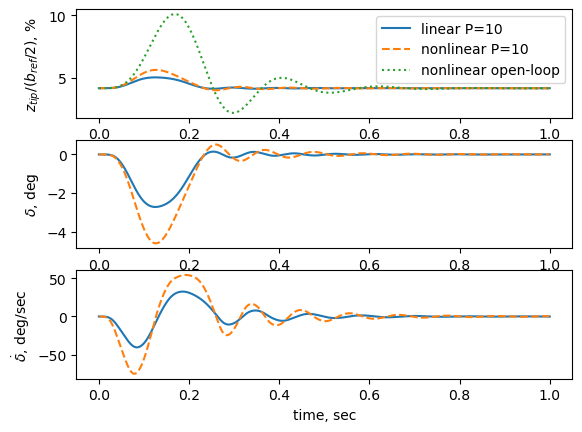

In [36]:
# Plot Data
fig, axs = plt.subplots(3, 1)
list_linestyles = ['-', '--', ':']
list_labels = ['linear P=10', 'nonlinear P=10', 'nonlinear open-loop']
axs[0].plot(time_array_linear, normalised_tip_deflection_linear[:,1], list_linestyles[0], label=list_labels[0])
axs[0].plot(time_array_nonlinear_closed_loop, 
            tip_displacement_nonlinear_P10, 
            list_linestyles[1], 
            label=list_labels[1])
axs[0].plot(time_array, normalised_tip_displacement, list_linestyles[-1], label=list_labels[-1])

axs[0].legend()
axs[0].set(ylabel='$z_{tip}/(b_{ref}/2)$, %')


axs[1].plot(time_array_linear, control_surface_deflection_deg[:,1], list_linestyles[0])
axs[1].plot(time_array_nonlinear_closed_loop, np.rad2deg(control_surface_input), list_linestyles[1])
    
axs[1].set(ylabel='$\delta$, deg')

axs[2].plot(time_array_linear, control_surface_deflection_rate_deg[:,0], list_linestyles[0])
axs[2].plot(time_array_nonlinear_closed_loop[1:], 
            delta_dot, 
            list_linestyles[1])
    
axs[2].set(ylabel='$\dot{\delta}$, deg/sec')
for ax in axs.flat:
    ax.set(xlabel='time, sec')